In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

train_path = 'train.csv'
train = pd.read_csv(train_path)
train.columns

Index(['id', 'Sex', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate',
       'Body_Temp', 'Calories'],
      dtype='object')

In [3]:

predictors = ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp']
target = 'z'
indices = train['Sex']=='male'


# Simple Linear Model

We adopt a 2-model solution, because the dataset for males and females is large enough separately.

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_log_error

from sklearn.linear_model import LinearRegression

indices = train['Sex']=='male'
train = train[indices]
X = train[predictors]
y = train['Calories']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred = np.clip(y_pred, 0, None)  # Ensure predictions are non-negative

error = root_mean_squared_log_error(y_test, y_pred)
print(f'Root Mean Squared Log Error: {error:.4f}')



Root Mean Squared Log Error: 0.6204


(array([  806., 16905., 25986., 23436., 20471., 19606., 17698., 17392.,
         7435.,   265.]),
 array([-45.73677124, -16.34593808,  13.04489508,  42.43572825,
         71.82656141, 101.21739458, 130.60822774, 159.99906091,
        189.38989407, 218.78072723, 248.1715604 ]),
 <BarContainer object of 10 artists>)

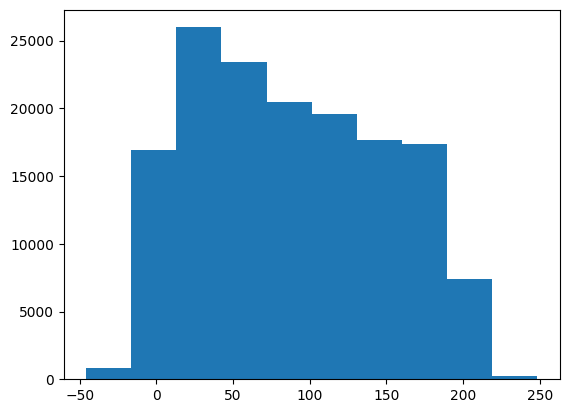

In [35]:
plt.hist(y_pred)

In [39]:
X_test[y_pred < 0]

,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
483421,20,179.0,78.0,5.0,83.0,39.2
563488,41,187.0,89.0,3.0,78.0,38.6
671247,30,191.0,102.0,2.0,74.0,38.8
505729,26,161.0,60.0,4.0,82.0,39.2
183330,21,154.0,56.0,4.0,80.0,38.9
...,...,...,...,...,...,...
426485,31,197.0,101.0,4.0,82.0,39.4
694450,29,192.0,88.0,4.0,77.0,38.9
475978,24,184.0,75.0,5.0,81.0,39.0
208232,40,152.0,51.0,3.0,78.0,38.8


# 2-model approach

## Males

In [ ]:
train_m = train[indices]
train_m.drop(columns=['id', 'Sex'])
X = train_m[predictors]
Z = np.log(1 + train_m['Calories'])

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
3,3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
7,7,male,46,188.0,94.0,23.0,100.0,40.8,145.0
9,9,male,65,185.0,88.0,23.0,104.0,41.0,185.0
10,10,male,20,186.0,89.0,21.0,94.0,40.3,86.0


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Compute Z from y (Calories) if not already computed
if 'Z' not in globals():
    Z = np.log(1 + y)

X_train, X_test, y_train, y_test = train_test_split(X, Z, test_size=0.2, random_state=42)
# Create and fit the linear regression model
model_males = LinearRegression()
model_males.fit(X_train, y_train)

print("Intercept:", model_males.intercept_)
print("Coefficients:", model_males.coef_)

Intercept: -27.216665953692434
Coefficients: [8.41194151e-03 1.92490476e-04 2.33147991e-03 2.55896725e-02
 2.85417651e-02 6.90125135e-01]


In [8]:
from sklearn.metrics import mean_squared_error
y_pred = model.predict(X_test)
error = mean_squared_error(y_test, y_pred)
error

np.float64(0.03271722724242383)

## Females

In [9]:
train_f = train[~indices]
train_f.drop(columns=['id', 'Sex'])
X = train_f[predictors]
Z = np.log(1 + train_f['Calories'])

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Compute Z from y (Calories) if not already computed
if 'Z' not in globals():
    Z = np.log(1 + y)

X_train, X_test, y_train, y_test = train_test_split(X, Z, test_size=0.2, random_state=42)
# Create and fit the linear regression model
model_females = LinearRegression()
model_females.fit(X_train, y_train)

from sklearn.metrics import mean_squared_error
y_pred = model_females.predict(X_test)
error = mean_squared_error(y_test, y_pred)
error

np.float64(0.02567014916163125)

# Joint Predictions

In [19]:
test = pd.read_csv('test.csv')
indices = test['Sex']=='male'


In [11]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          250000 non-null  int64  
 1   Sex         250000 non-null  object 
 2   Age         250000 non-null  int64  
 3   Height      250000 non-null  float64
 4   Weight      250000 non-null  float64
 5   Duration    250000 non-null  float64
 6   Heart_Rate  250000 non-null  float64
 7   Body_Temp   250000 non-null  float64
dtypes: float64(5), int64(2), object(1)
memory usage: 15.3+ MB


# Male model

In [20]:
# Separate the males
test_m = test[indices]
X_test_m = test_m[predictors]

# Train the model on the training set
model_males = LinearRegression()
X_train_m = train_m[predictors]
Z_train_m = np.log(1 + train_m['Calories'])
model_males.fit(X_train_m, Z_train_m)

# Predict on the test set
z_pred_males = model_males.predict(X_test_m)

# Female model

In [28]:
# Separate the males
test_f = test[~indices]
X_test_f = test_f[predictors]

# Train the model on the training set
model_females = LinearRegression()
X_train_f = train_f[predictors]
Z_train_f = np.log(1 + train_f['Calories'])
model_females.fit(X_train_f, Z_train_f)

# Predict on the test set
z_pred_females = model_females.predict(X_test_f)

# Merge

In [29]:
test['z'] = np.zeros(len(test))
test['z'][indices] = z_pred_males
test['z'][(~indices)] = z_pred_females

test['y'] = np.exp(test['z']) - 1

C:\Users\Sathya\AppData\Local\Temp\ipykernel_28276\1319873092.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  test['z'][indices] = z_pred_males
C:\Users\Sathya\AppData\Local\Temp\ipykernel_28276\1319873092.py:2: SettingWithCopyWarning: 


# Skorch MLP

In [1]:
import skorch
from skorch import NeuralNetRegressor
from skorch.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import pandas as pd
import torch
import torch.nn as nn
import numpy as np

train = pd.read_csv('train.csv')
indices = train['Sex']=='male'
train = train[indices]
train.drop(columns=['id','Sex'], inplace=True)
train['Dur_Squared'] = train['Duration']**2
train['Body_Temp_Squared'] = train['Body_Temp']**2
predictors = (list(train.columns))
predictors.remove('Calories')
X = train[predictors]
y = train['Calories']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = map(np.array, (X_train.values, X_test.values, y_train.values, y_test.values))


# Define PyTorch module
class MLP(nn.Module):
    def __init__(self, num_features=10, layer_widths=[32, 16]):
        super().__init__()
        self.hidden = nn.Sequential(
            nn.Linear(num_features, layer_widths[0]),
            nn.ReLU(),
            nn.Linear(layer_widths[0], layer_widths[1]),
            nn.ReLU(),
            nn.Linear(layer_widths[1], 1)
        )

    def forward(self, x):
        return self.hidden(x)

# Define RMSLE loss
class RMSLELoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, y_pred, y_true):
        y_pred = torch.clamp(y_pred, min=0)
        return torch.sqrt(torch.mean((torch.log1p(y_pred) - torch.log1p(y_true))**2))
# def rmsle_loss(y_pred, y_true):
#     y_pred = torch.clamp(y_pred, min=0)
#     return torch.sqrt(torch.mean((torch.log1p(y_pred) - torch.log1p(y_true))**2))

early_stop = EarlyStopping(monitor='valid_loss', patience=10, lower_is_better=True)
# Wrap in skorch
net = NeuralNetRegressor(
    MLP(num_features=X_train.shape[1], layer_widths=[32, 16]),
    max_epochs=100,
    lr=0.01,
    criterion=RMSLELoss,
    optimizer=torch.optim.Adam,
    callbacks=[early_stop],
    train_split=skorch.dataset.ValidSplit(0.2),
    device='cpu'
)

net.fit(X_train.astype(np.float32), y_train.astype(np.float32).reshape(-1, 1))

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.1868        0.1305  6.4172
      2        0.1083        0.0899  5.6854
      3        0.0985        0.0834  5.7054
      4        0.0945        0.0875  5.7447
      5        0.0932        0.0889  5.7216
      6        0.0924        0.0901  5.6387
      7        0.0922        0.0873  5.6463
      8        0.0910        0.0816  5.6691
      9        0.0903        0.0845  5.7652
     10        0.0899        0.0807  5.7799
     11        0.0898        0.0848  5.6938
     12        0.0897        0.0864  5.6238
     13        0.0891        0.0906  5.7026
     14        0.0888        0.0802  5.7313
     15        0.0879        0.0896  5.6294
     16        0.0872        0.0861  5.7406
     17        0.0871        0.0808  5.7945
     18        0.0868        0.0811  7.8141
     19        0.0865        0.0850  7.5694
     20        0.0860        0.0823  6.2927
     21        0.0852        0.0

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=MLP(
    (hidden): Sequential(
      (0): Linear(in_features=8, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=16, bias=True)
      (3): ReLU()
      (4): Linear(in_features=16, out_features=1, bias=True)
    )
  ),
)

In [2]:
from sklearn.metrics import root_mean_squared_log_error
with torch.no_grad():
    y_pred = net.predict(X_test.astype(np.float32))
    y_pred = np.clip(y_pred, 0, None)  # Ensure predictions are non-negative
    error = root_mean_squared_log_error(y_test, y_pred)

    print(f'Root Mean Squared Log Error: {error:.4f}')

Root Mean Squared Log Error: 0.0856


# XGB

In [6]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
from typing import Tuple

def gradient(predt: np.ndarray, dtrain: xgb.DMatrix) -> np.ndarray:
    '''Compute the gradient squared log error.'''
    y = dtrain.get_label()
    return (np.log1p(predt) - np.log1p(y)) / (predt + 1)

def hessian(predt: np.ndarray, dtrain: xgb.DMatrix) -> np.ndarray:
    '''Compute the hessian for squared log error.'''
    y = dtrain.get_label()
    return ((-np.log1p(predt) + np.log1p(y) + 1) /
            np.power(predt + 1, 2))

def squared_log(predt: np.ndarray,
                dtrain: xgb.DMatrix) -> Tuple[np.ndarray, np.ndarray]:
    '''Squared Log Error objective. A simplified version for RMSLE used as
    objective function.
    '''

    grad = gradient(predt, dtrain)
    hess = hessian(predt, dtrain)
    return grad, hess

def rmsle(predt: np.ndarray, dtrain: xgb.DMatrix) -> Tuple[str, float]:
    ''' Root mean squared log error metric.'''
    y = dtrain.get_label()
    predt[predt < -1] = -1 + 1e-6
    elements = np.power(np.log1p(y) - np.log1p(predt), 2)
    return 'PyRMSLE', float(np.sqrt(np.sum(elements) / len(y)))

train = pd.read_csv('train.csv')
train['Sex'] = train['Sex'].astype('category')
# indices = train['Sex']=='male'
# train = train[indices]
# train.drop(columns=['id','Sex'], inplace=True)
# train['Dur_Squared'] = train['Duration']**2
# train['Body_Temp_Squared'] = train['Body_Temp']**2
predictors = (list(train.columns))
predictors.remove('Calories')
X = train[predictors]
y = train['Calories']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# X_train, X_test, y_train, y_test = map(np.array, (X_train.values, X_test.values, y_train.values, y_test.values))

dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)

results = {}
params = {
    # 'objective': 'reg:squarederror',  # Regression task
    'tree_method': 'hist',           # Faster histogram-based method
    'learning_rate': 0.1,           # Smaller learning rate for better convergence
    'max_depth': 10,                  # Depth of trees to control overfitting
    'min_child_weight': 3,           # Minimum sum of instance weight needed in a child
    'subsample': 0.8,                # Fraction of samples used for training each tree
    'colsample_bytree': 0.8,         # Fraction of features used for each tree
    'lambda': 1.0,                   # L2 regularization term
    'alpha': 1,                    # L1 regularization term
    'seed': 42,                      # Random seed for reproducibility
    'disable_default_eval_metric': 1 # Disable default metric to use custom RMSLE
}
xgb.train({'tree_method': 'hist', 'seed': 1994,
           'disable_default_eval_metric': 1},
          dtrain=dtrain,
          num_boost_round=1000,
          obj=squared_log,
          custom_metric=rmsle,
          evals=[(dtrain, 'dtrain'), (dtest, 'dtest')],
          evals_result=results)

[0]	dtrain-PyRMSLE:3.65176	dtest-PyRMSLE:3.65145
[1]	dtrain-PyRMSLE:3.44835	dtest-PyRMSLE:3.44801
[2]	dtrain-PyRMSLE:3.24788	dtest-PyRMSLE:3.24754
[3]	dtrain-PyRMSLE:3.05061	dtest-PyRMSLE:3.05024
[4]	dtrain-PyRMSLE:2.85677	dtest-PyRMSLE:2.85639
[5]	dtrain-PyRMSLE:2.66663	dtest-PyRMSLE:2.66624
[6]	dtrain-PyRMSLE:2.48050	dtest-PyRMSLE:2.48009
[7]	dtrain-PyRMSLE:2.29868	dtest-PyRMSLE:2.29825
[8]	dtrain-PyRMSLE:2.12151	dtest-PyRMSLE:2.12106
[9]	dtrain-PyRMSLE:1.94937	dtest-PyRMSLE:1.94891
[10]	dtrain-PyRMSLE:1.78262	dtest-PyRMSLE:1.78214
[11]	dtrain-PyRMSLE:1.62169	dtest-PyRMSLE:1.62120
[12]	dtrain-PyRMSLE:1.46698	dtest-PyRMSLE:1.46648
[13]	dtrain-PyRMSLE:1.31895	dtest-PyRMSLE:1.31845
[14]	dtrain-PyRMSLE:1.17813	dtest-PyRMSLE:1.17759
[15]	dtrain-PyRMSLE:1.04490	dtest-PyRMSLE:1.04434
[16]	dtrain-PyRMSLE:0.91981	dtest-PyRMSLE:0.91923
[17]	dtrain-PyRMSLE:0.80340	dtest-PyRMSLE:0.80282
[18]	dtrain-PyRMSLE:0.69609	dtest-PyRMSLE:0.69550
[19]	dtrain-PyRMSLE:0.59836	dtest-PyRMSLE:0.59776
[20]	dtrai

In [7]:
xgb.plot_importance(model, importance_type='weight', max_num_features=10)  # Top 10 features
plt.title("Feature Importance")
plt.show()

NameError: name 'model' is not defined

Generate Predictions

In [11]:
train = pd.read_csv('train.csv')
train['Sex'] = train['Sex'].astype('category')
test = pd.read_csv('test.csv')
test['Sex'] = test['Sex'].astype('category')
X_train = train.drop(columns=['id', 'Calories'])
y_train = train['Calories']
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
X_test = test.drop(columns=['id'])

dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
dval = xgb.DMatrix(X_val, label=y_val, enable_categorical=True)
dtest = xgb.DMatrix(X_test, enable_categorical=True)

model = xgb.train({'tree_method': 'hist', 'seed': 1994,
           'disable_default_eval_metric': 1},
          dtrain=dtrain,
          num_boost_round=1000,
          obj=squared_log,
          custom_metric=rmsle,
          evals=[(dtrain, 'dtrain'), (dval, 'dval')],
          evals_result=results)

[0]	dtrain-PyRMSLE:3.65176	dval-PyRMSLE:3.65145
[1]	dtrain-PyRMSLE:3.44835	dval-PyRMSLE:3.44801
[2]	dtrain-PyRMSLE:3.24788	dval-PyRMSLE:3.24754
[3]	dtrain-PyRMSLE:3.05061	dval-PyRMSLE:3.05024
[4]	dtrain-PyRMSLE:2.85677	dval-PyRMSLE:2.85639
[5]	dtrain-PyRMSLE:2.66663	dval-PyRMSLE:2.66624
[6]	dtrain-PyRMSLE:2.48050	dval-PyRMSLE:2.48009
[7]	dtrain-PyRMSLE:2.29868	dval-PyRMSLE:2.29825
[8]	dtrain-PyRMSLE:2.12151	dval-PyRMSLE:2.12106
[9]	dtrain-PyRMSLE:1.94937	dval-PyRMSLE:1.94891
[10]	dtrain-PyRMSLE:1.78262	dval-PyRMSLE:1.78214
[11]	dtrain-PyRMSLE:1.62169	dval-PyRMSLE:1.62120
[12]	dtrain-PyRMSLE:1.46698	dval-PyRMSLE:1.46648
[13]	dtrain-PyRMSLE:1.31895	dval-PyRMSLE:1.31845
[14]	dtrain-PyRMSLE:1.17813	dval-PyRMSLE:1.17759
[15]	dtrain-PyRMSLE:1.04490	dval-PyRMSLE:1.04434
[16]	dtrain-PyRMSLE:0.91981	dval-PyRMSLE:0.91923
[17]	dtrain-PyRMSLE:0.80340	dval-PyRMSLE:0.80282
[18]	dtrain-PyRMSLE:0.69609	dval-PyRMSLE:0.69550
[19]	dtrain-PyRMSLE:0.59836	dval-PyRMSLE:0.59776
[20]	dtrain-PyRMSLE:0.51050	dv

In [12]:
dtest = xgb.DMatrix(X_test, enable_categorical=True)
y_pred = model.predict(dtest)

NameError: name 'plt' is not defined

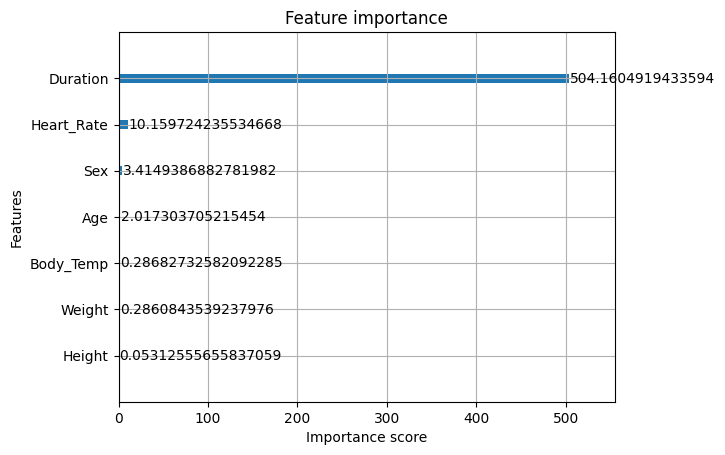

In [15]:
xgb.plot_importance(model, importance_type='gain', max_num_features=10)  # Top 10 features
plt.title("Feature Importance")

# LightGBM

C:\Users\Sathya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lightgbm\plotting.py:382: UserWarning: More than one metric available, picking one to plot.
  _log_warning("More than one metric available, picking one to plot.")


Root Mean Squared Log Error: 0.06191234045990264


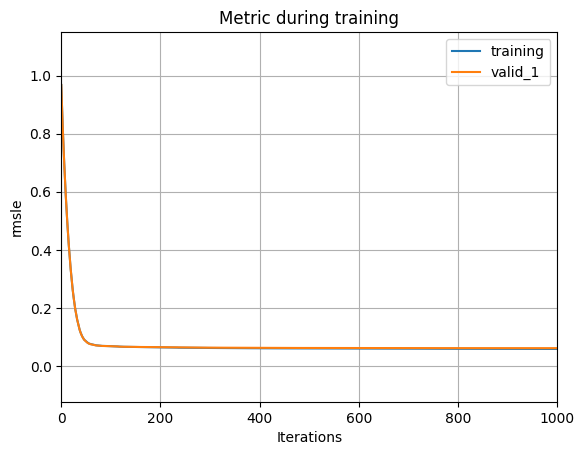

In [14]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from custom_loss import rmsle_lgb_obj, rmsle_lgb_eval

train = pd.read_csv('train.csv')
enc = LabelEncoder()
train['Sex'] = enc.fit_transform(train['Sex'])

X = train.drop(columns=['id', 'Calories'])
y = train['Calories']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create LightGBM datasets
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_eval = lgb.Dataset(X_test, label=y_test, reference=lgb_train)

# Import the custom loss function from the custom_loss module

# Set up parameters (excluding objective since it is provided as a custom function)
params = {
    # "objective": rmsle_lgb_obj,
    "learning_rate": 0.1,
    "max_depth": -1,
    "verbose": -1,
    "seed": 42,
}

evals = {}
# Train the LGBM regressor using the custom loss function
model = lgb.train(params,
                  lgb_train,
                  num_boost_round=1000,
                  feval=rmsle_lgb_eval,
                  valid_sets=[lgb_train, lgb_eval],
                #   early_stopping_rounds=10,
                callbacks = [lgb.record_evaluation(evals)]
                )

lgb.plot_metric(evals)

# Predict and compute RMSLE
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
rmsle = np.sqrt(np.mean((np.log1p(y_test) - np.log1p(y_pred))**2))
print("Root Mean Squared Log Error:", rmsle)


In [17]:
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()

train = pd.read_csv('train.csv')
train['Sex'] = enc.fit_transform(train['Sex'])
X_train = train.drop(columns=['id', 'Calories'])
y_train = train['Calories']
lgb_train = lgb.Dataset(X_train, label=y_train)

test = pd.read_csv('test.csv')
test['Sex'] = enc.transform(test['Sex'])
X_test = test.drop(columns=['id'])
# y_train = test['Calories']
# lgb_test = lgb.Dataset(X_test)

model = lgb.train(params,
                  lgb_train,
                  num_boost_round=1000,
                  feval=rmsle_lgb_eval,
                #   valid_sets=[lgb_train, lgb_eval],
                #   early_stopping_rounds=10,
                # callbacks = [lgb.record_evaluation(evals)]
                )

y_pred = model.predict(X_test)




In [23]:
# plt.hist(y_pred)

y_pred = np.clip(y_pred, 0, None)  # Ensure predictions are non-negative

# Averaging LGB and XGB

In [6]:
import pandas as pd
import xgboost as xgb
import lightgbm as lgb
from custom_loss import rmsle_lgb_obj, rmsle_lgb_eval, squared_log, rmsle
from sklearn.preprocessing import LabelEncoder

enc = LabelEncoder()

train = pd.read_csv('train.csv')
train['Sex'] = enc.fit_transform(train['Sex'])
X_train = train.drop(columns=['id', 'Calories'])
y_train = train['Calories']
lgb_train = lgb.Dataset(X_train, label=y_train)

test = pd.read_csv('test.csv')
test['Sex'] = enc.transform(test['Sex'])
X_test = test.drop(columns=['id'])

params = {
    # "objective": rmsle_lgb_obj,
    "learning_rate": 0.1,
    "max_depth": -1,
    "verbose": -1,
    "seed": 42,
}
model_lgb = lgb.train(params,
                  lgb_train,
                  num_boost_round=1000,
                  feval=rmsle_lgb_eval,
                #   valid_sets=[lgb_train, lgb_eval],
                #   early_stopping_rounds=10,
                # callbacks = [lgb.record_evaluation(evals)]
                )

dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
dtest = xgb.DMatrix(X_test, enable_categorical=True)
results = {}
model_xgb = xgb.train({'tree_method': 'hist', 'seed': 1994,
           'disable_default_eval_metric': 1},
          dtrain=dtrain,
          num_boost_round=1000,
          obj=squared_log,
          custom_metric=rmsle,
          evals=[(dtrain, 'dtrain')],
          evals_result=results)

y_pred_xgb = model_xgb.predict(dtest)
y_pred_lgb = model_lgb.predict(X_test)

y_pred = (y_pred_xgb + y_pred_lgb) / 2

[0]	dtrain-PyRMSLE:3.65170
[1]	dtrain-PyRMSLE:3.44828
[2]	dtrain-PyRMSLE:3.24781
[3]	dtrain-PyRMSLE:3.05053
[4]	dtrain-PyRMSLE:2.85668
[5]	dtrain-PyRMSLE:2.66654
[6]	dtrain-PyRMSLE:2.48039
[7]	dtrain-PyRMSLE:2.29855
[8]	dtrain-PyRMSLE:2.12136
[9]	dtrain-PyRMSLE:1.94920
[10]	dtrain-PyRMSLE:1.78241
[11]	dtrain-PyRMSLE:1.62143
[12]	dtrain-PyRMSLE:1.46666
[13]	dtrain-PyRMSLE:1.31855
[14]	dtrain-PyRMSLE:1.17760
[15]	dtrain-PyRMSLE:1.04427
[16]	dtrain-PyRMSLE:0.91905
[17]	dtrain-PyRMSLE:0.80244
[18]	dtrain-PyRMSLE:0.69488
[19]	dtrain-PyRMSLE:0.59690
[20]	dtrain-PyRMSLE:0.50867
[21]	dtrain-PyRMSLE:0.43065
[22]	dtrain-PyRMSLE:0.36250
[23]	dtrain-PyRMSLE:0.30422
[24]	dtrain-PyRMSLE:0.25567
[25]	dtrain-PyRMSLE:0.21575
[26]	dtrain-PyRMSLE:0.18371
[27]	dtrain-PyRMSLE:0.15799
[28]	dtrain-PyRMSLE:0.13845
[29]	dtrain-PyRMSLE:0.12324
[30]	dtrain-PyRMSLE:0.11210
[31]	dtrain-PyRMSLE:0.10386
[32]	dtrain-PyRMSLE:0.09761
[33]	dtrain-PyRMSLE:0.09249
[34]	dtrain-PyRMSLE:0.08808
[35]	dtrain-PyRMSLE:0.08489
[3

# LGB via target variable transformation

have xgb predict log1p(calories), then invert

In [11]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()

train = pd.read_csv('train.csv')
train['Sex'] = enc.fit_transform(train['Sex'])
X_train = train.drop(columns=['id', 'Calories'])
y_train = train['Calories']
z_train = np.log1p(y_train)
lgb_train = lgb.Dataset(X_train, label=z_train)

test = pd.read_csv('test.csv')
test['Sex'] = enc.transform(test['Sex'])
X_test = test.drop(columns=['id'])
# y_train = test['Calories']
# lgb_test = lgb.Dataset(X_test)

model = lgb.train(params,
                  lgb_train,
                  num_boost_round=1000,
                #   feval=rmsle_lgb_eval,
                #   valid_sets=[lgb_train, lgb_eval],
                #   early_stopping_rounds=10,
                # callbacks = [lgb.record_evaluation(evals)]
                )

z_pred = model.predict(X_test)
y_pred = np.expm1(z_pred)
y_pred = np.clip(y_pred, 0, None)  # Ensure predictions are non-negative

# XGB via Target Transformation

In [ ]:
train = pd.read_csv('train.csv')
train['Sex'] = train['Sex'].astype('category')
test = pd.read_csv('test.csv')
test['Sex'] = test['Sex'].astype('category')
X_train = train.drop(columns=['id', 'Calories'])
y_train = train['Calories']
z_train = np.log1p(y_train)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
X_test = test.drop(columns=['id'])

dtrain = xgb.DMatrix(X_train, label=z_train, enable_categorical=True)
# dval = xgb.DMatrix(X_val, label=y_val, enable_categorical=True)
dtest = xgb.DMatrix(X_test, enable_categorical=True)

model = xgb.train({'tree_method': 'hist', 'seed': 1994,
        #    'disable_default_eval_metric': 1
            },
          dtrain=dtrain,
          num_boost_round=1000,
        #   obj=squared_log,
        #   custom_metric=rmsle,
          evals=[(dtrain, 'dtrain')],
          evals_result=results)

z_pred = model.predict(dtest)
y_pred = np.expm1(z_pred)
y_pred = np.clip(y_pred, 0, None)  # Ensure predictions are non-negative

# Averaging XGB, LGB using target transformation

In [17]:
enc = LabelEncoder()

train = pd.read_csv('train.csv')
train['Sex'] = enc.fit_transform(train['Sex'])
X_train = train.drop(columns=['id', 'Calories'])
y_train = train['Calories']
z__train = np.log1p(y_train)
lgb_train = lgb.Dataset(X_train, label=z_train)

test = pd.read_csv('test.csv')
test['Sex'] = enc.transform(test['Sex'])
X_test = test.drop(columns=['id'])

params = {
    # "objective": rmsle_lgb_obj,
    "learning_rate": 0.1,
    "max_depth": -1,
    "verbose": -1,
    "seed": 42,
}
model_lgb = lgb.train(params,
                  lgb_train,
                  num_boost_round=1000,
                #   feval=rmsle_lgb_eval,
                #   valid_sets=[lgb_train, lgb_eval],
                #   early_stopping_rounds=10,
                # callbacks = [lgb.record_evaluation(evals)]
                )

dtrain = xgb.DMatrix(X_train, label=z_train, enable_categorical=True)
dtest = xgb.DMatrix(X_test, enable_categorical=True)
results = {}
model_xgb = xgb.train({'tree_method': 'hist', 'seed': 1994,},
          dtrain=dtrain,
          num_boost_round=1000,
        #   obj=squared_log,
        #   custom_metric=rmsle,
          evals=[(dtrain, 'dtrain')],
          evals_result=results)

z_pred_xgb = model_xgb.predict(dtest)
z_pred_lgb = model_lgb.predict(X_test)

z_pred = (z_pred_xgb + z_pred_lgb) / 2
y_pred = np.expm1(z_pred)
y_pred = np.clip(y_pred, 0, None)  # Ensure predictions are non-negative

[0]	dtrain-rmse:0.68122
[1]	dtrain-rmse:0.48459
[2]	dtrain-rmse:0.34795
[3]	dtrain-rmse:0.25344
[4]	dtrain-rmse:0.18851
[5]	dtrain-rmse:0.14463
[6]	dtrain-rmse:0.11555
[7]	dtrain-rmse:0.09699
[8]	dtrain-rmse:0.08554
[9]	dtrain-rmse:0.07796
[10]	dtrain-rmse:0.07320
[11]	dtrain-rmse:0.07048
[12]	dtrain-rmse:0.06874
[13]	dtrain-rmse:0.06739
[14]	dtrain-rmse:0.06653
[15]	dtrain-rmse:0.06591
[16]	dtrain-rmse:0.06553
[17]	dtrain-rmse:0.06514
[18]	dtrain-rmse:0.06487
[19]	dtrain-rmse:0.06470
[20]	dtrain-rmse:0.06448
[21]	dtrain-rmse:0.06431
[22]	dtrain-rmse:0.06412
[23]	dtrain-rmse:0.06404
[24]	dtrain-rmse:0.06387
[25]	dtrain-rmse:0.06375
[26]	dtrain-rmse:0.06334
[27]	dtrain-rmse:0.06321
[28]	dtrain-rmse:0.06307
[29]	dtrain-rmse:0.06302
[30]	dtrain-rmse:0.06297
[31]	dtrain-rmse:0.06284
[32]	dtrain-rmse:0.06280
[33]	dtrain-rmse:0.06266
[34]	dtrain-rmse:0.06245
[35]	dtrain-rmse:0.06230
[36]	dtrain-rmse:0.06220
[37]	dtrain-rmse:0.06214
[38]	dtrain-rmse:0.06212
[39]	dtrain-rmse:0.06206
[40]	dtrai

# Submit

Change submission name when 

In [18]:
def generate_submission(y_pred, submission_name):
    
    df_submission = pd.read_csv('sample_submission.csv')
    df_submission['Calories'] = y_pred
    df_submission.to_csv(submission_name, index=False)

submission_name = 'avg_target_transformation_xgb_lgb'
generate_submission(y_pred, f'submissions\\{submission_name}.csv')